## 実習4-2
### CIFER-10をCNNで分類
#### 目的
Data Augmentationによる精度上昇を確認

In [1]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator #data augmentationするため
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import os
import matplotlib.pyplot as plt
import numpy as np
import time

Using TensorFlow backend.


In [0]:
batch_size = 50
num_classes = 10
epochs = 10
data_augmentation = True #data augmentationを実行するときはTrueに設定

In [0]:
# イメージサイズの設定
img_rows, img_cols = 32, 32

In [4]:
# CIFAR-10データをダウンロード。既に訓練データとテストデータに分割されている。
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

170500096/170498071 [==============================] - 3s 0us/step
50000 train samples
10000 test samples


In [0]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 1)
#"channels_first"の場合、入力のshapeは(batch, channels, row, column)となり,
#"channels_last"の場合，入力のshapeは(batch, row, column, channels)となります。

In [6]:
#学習用の画像とラベル
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

#テスト用の画像とラベル
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


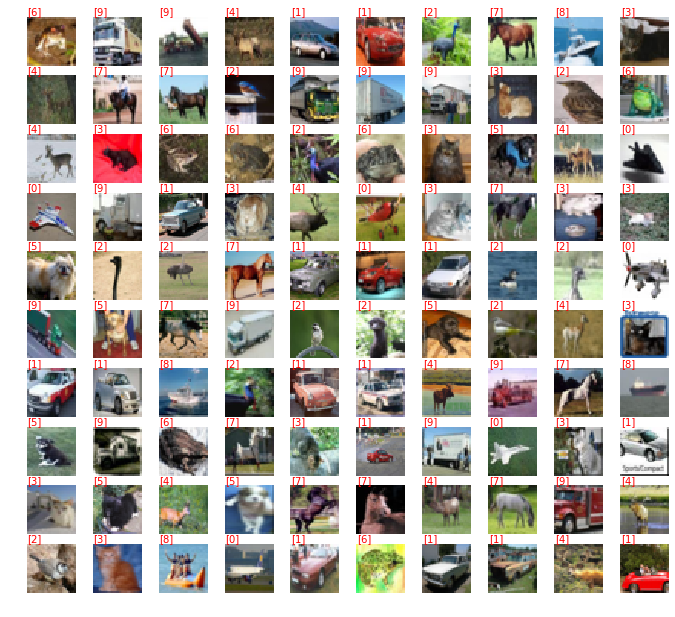

In [7]:
#10x10でラベルと画像を同時に表示
for i in range(100):
    plt.subplot(10,10,i + 1)
    plt.axis("off")
    plt.imshow(x_train[i,:32,:32])
    plt.text(0, -2, y_train[i], fontsize=10, color='red') #ラベルの数字の設定
    plt.subplots_adjust(left=0, right=1.5, top=2, bottom=0) #画像間のマージンを設定
plt.show()

In [8]:
#各数字がそれぞれ何個ずつあるかカウント(データ数に偏りがないことを確認)
a, b = np.unique(y_train, return_counts=True)
c, d = np.unique(y_test, return_counts=True)
print(dict(zip(a, b)))
print(dict(zip(c, d)))

"""
0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'
"""

{0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000, 9: 5000}
{0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}


"\n0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'\n"

In [0]:
# 教師データ(y_train, y_test)をOne hotなベクトルへ変換する
Y_train = keras.utils.to_categorical(y_train, num_classes)
Y_test = keras.utils.to_categorical(y_test, num_classes)

In [10]:
#One hotベクトルになっていることを確認
Y_train[0:10]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [0]:
#データの値を正規化
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [12]:
#CNNのモデル/構造
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()#モデルの内容を表示






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         


In [0]:
# RMSprop optimizerの初期化
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)


In [14]:
# モデルのコンパイル
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [15]:
# 計算開始
start = time.time() #処理を始めた時間を記録
if not data_augmentation:
    print('Not using data augmentation.')
    hist = model.fit(x_train, Y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, Y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # 以下でData Augmentationを行う:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # サンプル平均を0にする。
        featurewise_std_normalization=False,  # サンプルを標準偏差で割る。
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # ZCA白色化
        rotation_range=0,  # 画像を指定の角度でランダムに回転させる
        width_shift_range=0.1,  # 画像を水平方向にランダムに移動する。 (0-1,1は画像サイズを基準にしている)
        height_shift_range=0.1,  # 画像を垂直方向にランダムに移動する。 (0-1,1は画像サイズを基準にしている)
        horizontal_flip=True,  # 画像を水平方向にランダムに反転する。
        vertical_flip=False)  # 画像を垂直方向にランダムに反転する。
    
    # 水増し画像を訓練用画像の形式に合わせる
    datagen.fit(x_train)

    # datagen.flow()によって前処理されたbatchを使うときはmodel.fit_generatorを用いる
    hist = model.fit_generator(datagen.flow(x_train, Y_train,
                                            batch_size=batch_size),
                                            steps_per_epoch = 50000/batch_size, #1epochで用いるminibatchの数
                                            epochs=epochs,
                                            validation_data=(x_test, Y_test),
                                            workers=4,
                                            )

elapsed_time = time.time() - start #(処理時間)＝(処理が終わった時間)ー(処理を始めた時間)
print("計算時間:",elapsed_time,"秒") 

# lossとAccuracyを出す
scores = model.evaluate(x_test, Y_test, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Using real-time data augmentation.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/10





1000/1000 [==============================] - 304s 304ms/step - loss: 1.9107 - acc: 0.2974 - val_loss: 1.6100 - val_acc: 0.4141
Epoch 2/10
1000/1000 [==============================] - 304s 304ms/step - loss: 1.6300 - acc: 0.4008 - val_loss: 1.4822 - val_acc: 0.4575
Epoch 3/10
1000/1000 [==============================] - 307s 307ms/step - loss: 1.5166 - acc: 0.4480 - val_loss: 1.3557 - val_acc: 0.5088
Epoch 4/10
1000/1000 [==============================] - 301s 301ms/step - loss: 1.4375 - acc: 0.4812 - val_loss: 1.3027 - val_acc: 0.5329
Epoch 5/10
1000/1000 [==============================] - 298s 298ms/step - loss: 1.3763 - acc: 0.5061 - val_loss: 1.2398 - val_acc: 0.5560
Epoch 6/10
1000/1000 [==============================] - 296s 296ms/step - loss: 1.3215 - acc: 0.5285 - val_loss: 1.4103 - val_acc: 0.5117
Epoch 7/10
1000/1000 [=============

In [16]:
# モデルと重みの保存
save_dir = os.path.join(os.getcwd(), 'saved_models') #os.path.join(a,b)でa/bのようにパスを作る。os.getwed()はカレントディレクトリ
model_name = 'keras_cifar10_trained_model.h5'

if not os.path.isdir(save_dir):#'saved_models'というフォルダが無ければ作る
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)#保存先のパスを指定
model.save(model_path)#モデルの保存
print('Saved trained model at %s ' % model_path)


Saved trained model at /content/saved_models/keras_cifar10_trained_model.h5 


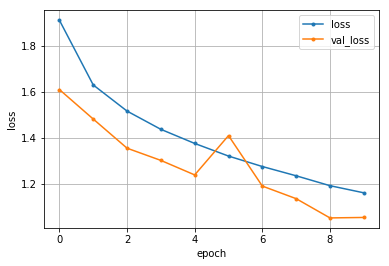

In [17]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

# lossのグラフ
plt.plot(range(epochs), loss, marker='.', label='loss')
plt.plot(range(epochs), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

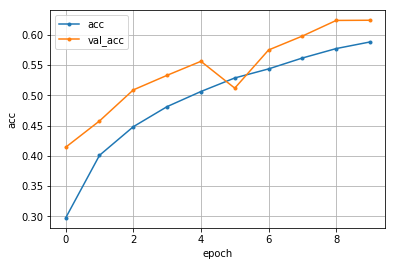

In [18]:
acc = hist.history['acc']
val_acc = hist.history['val_acc']

# accuracyのグラフ
plt.plot(range(epochs), acc, marker='.', label='acc')
plt.plot(range(epochs), val_acc, marker='.', label='val_acc')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

In [19]:
# CNNの予測値を出力
preds = model.predict(x_test) #softmax後の数値を出力
cls = model.predict_classes(x_test) #予測したクラスを出力
print(preds[0:5])
print(cls[0:5])
print(y_test[0:5]) #予測クラスと教師を比較

[[5.8326148e-03 1.5555299e-03 1.9372592e-02 4.3022156e-01 1.5709288e-02
  4.3049866e-01 5.9332591e-02 1.3887391e-02 1.2709376e-02 1.0880440e-02]
 [7.6640218e-02 5.8499408e-01 1.3448493e-04 2.1321954e-05 3.3332111e-05
  9.7548059e-07 7.2844482e-06 8.5622314e-06 2.7705359e-01 6.1106097e-02]
 [5.0789416e-02 5.4557705e-01 1.1225854e-03 1.4395791e-03 1.1775118e-03
  2.0304319e-04 3.4347360e-04 7.6608371e-04 2.0820478e-01 1.9037642e-01]
 [5.2437162e-01 1.3746482e-01 9.1763837e-03 1.2727195e-03 4.0395712e-03
  1.1345031e-04 6.2348897e-04 1.1989720e-03 2.9568040e-01 2.6058558e-02]
 [1.9152842e-06 1.1116007e-05 3.2797258e-03 1.3919765e-02 2.5678083e-02
  1.1433440e-03 9.5590353e-01 5.1284340e-05 1.8908773e-06 9.3857161e-06]]
[5 1 1 0 6]
[[3]
 [8]
 [8]
 [0]
 [6]]
